In [1]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [2]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs

Please replace `YOUR_API_KEY` with the assigned API key string. Note that it should be without quotes.

For example, if the assigned API Key is `abcd1234`, you can do the following

```python
%env ROCKFISH_API_KEY=abcd1234
conn = rf.Connection.from_env()
```

If you do not have API Key, please reach out to support@rockfish.ai.


In [3]:
%env ROCKFISH_API_KEY=YOUR_API_KEY
conn = rf.Connection.from_env()

In [4]:
# download our example of tabular data: spotify-2023-short.csv
!wget --no-clobber https://docs.rockfish.ai/tutorials/spotify-2023-short.csv

--2024-12-12 18:56:21--  https://docs.rockfish.ai/tutorials/spotify-2023-short.csv
Resolving docs.rockfish.ai (docs.rockfish.ai)... 

I0000 00:00:1734058581.487147 8426840 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


2600:9000:249b:2400:3:1cb5:3480:93a1, 2600:9000:249b:5800:3:1cb5:3480:93a1, 2600:9000:249b:9e00:3:1cb5:3480:93a1, ...
Connecting to docs.rockfish.ai (docs.rockfish.ai)|2600:9000:249b:2400:3:1cb5:3480:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2759 (2.7K) [text/csv]
Saving to: ‘spotify-2023-short.csv’

spotify-2023-short. 100%[===================>]   2.69K  --.-KB/s    in 0s      

2024-12-12 18:56:21 (439 MB/s) - ‘spotify-2023-short.csv’ saved [2759/2759]



In [5]:
dataset = rf.Dataset.from_csv("Spotify", "spotify-2023-short.csv")
dataset.to_pandas()

,released_year,released_month,released_day,in_spotify_playlists,bpm,key,mode
0,2023,7,14,553,125,B,Major
1,2023,3,23,1474,92,C#,Major
2,2023,6,30,1397,138,F,Major
3,2019,8,23,7858,170,A,Major
4,2023,5,18,3133,144,A,Minor
...,...,...,...,...,...,...,...
95,2023,5,12,2175,143,D#,Major
96,2023,3,17,2000,100,F#,Minor
97,2022,12,9,2839,143,F,Major
98,2011,1,1,20333,112,C#,Minor


In [6]:
cat_fields = "released_year released_month released_day key mode".split()
con_fields = "in_spotify_playlists bpm".split()
config = {
    "encoder": {
        "metadata": [
            {"field": col, "type": "categorical"} for col in cat_fields
        ]
        + [{"field": col, "type": "continuous"} for col in con_fields]
    },
    "rtf": {
        "mode": "tabular",
        "num_bootstrap": 2,
        "tabular": {
            "epochs": 1,
            "transformer": {
                "gpt2_config": {"layer": 1, "head": 1, "embed": 1}
            },
        },
    },
}
# create the train action
train = ra.TrainTransformer(config)

In [7]:
builder = rf.WorkflowBuilder()
builder.add_dataset(dataset)
builder.add_action(train, parents=[dataset])
workflow = await builder.start(conn)

print(f"Workflow: {workflow.id()}")

Workflow: oKRZ61q2mHZ4CueLnO3ee


In [8]:
async for log in workflow.logs():
    print(log)

2024-12-13T02:56:31Z dataset-load: INFO Loading dataset 'pbI2zc5PK3r341IBGZ9Dn' with 100 rows
2024-12-13T02:56:34Z train-transformer: WARN Missing values detected in Field "key".
2024-12-13T02:56:34Z train-transformer: INFO Start training...
2024-12-13T02:56:36Z train-transformer: INFO Epoch 1 completed.
2024-12-13T02:56:46Z train-transformer: INFO Training completed. The Model ID is e33222ac-b8fd-11ef-9e7e-665e8c8b87d7


In [9]:
model = await workflow.models().last()
model

Model(id='e33222ac-b8fd-11ef-9e7e-665e8c8b87d7', labels={'workflow_id': 'oKRZ61q2mHZ4CueLnO3ee'}, create_time=datetime.datetime(2024, 12, 13, 2, 56, 44, tzinfo=datetime.timezone.utc), size_bytes=127776256)

In [10]:
generate = ra.GenerateTransformer(config)
save = ra.DatasetSave({"name": "synthetic"})
builder = rf.WorkflowBuilder()
builder.add_model(model)
builder.add_action(generate, parents=[model])
builder.add_action(save, parents=[generate])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 1YizqvakLxdHttG4i9HJNV


In [11]:
async for log in workflow.logs():
    print(log)

2024-12-13T02:56:48Z generate-transformer: INFO Starting download of Model e33222ac-b8fd-11ef-9e7e-665e8c8b87d7
2024-12-13T02:56:54Z generate-transformer: INFO Finished download of Model e33222ac-b8fd-11ef-9e7e-665e8c8b87d7
2024-12-13T02:56:54Z generate-transformer: INFO Start generating samples...
2024-12-13T02:56:54Z generate-transformer: INFO Finish generating samples...
2024-12-13T02:56:55Z dataset-save: INFO Saved dataset '1EifsdkwAA2osoP4NCPSty' with 100 rows


In [12]:
syn = None
async for sds in workflow.datasets():
    syn = await sds.to_local(conn)
syn.table = syn.table.select(
    "released_year released_month released_day in_spotify_playlists bpm key mode".split()
)
syn.to_pandas()

,released_year,released_month,released_day,in_spotify_playlists,bpm,key,mode
0,2029,3,13,2415,61,D,Major
1,2029,11,13,13523,62,A#,Major
2,2017,4,3,7428,20,E,Major
3,2023,2,5,5809,108,A,Minor
4,2026,9,35,42257,109,None,Major
...,...,...,...,...,...,...,...
95,2071,16,31,27804,183,F,Major
96,2020,2,25,3772,169,G#,Minor
97,2022,3,4,2531,124,F,Minor
98,2022,9,21,16839,128,F,Major


### Evaluation

**1. Categorical columns**


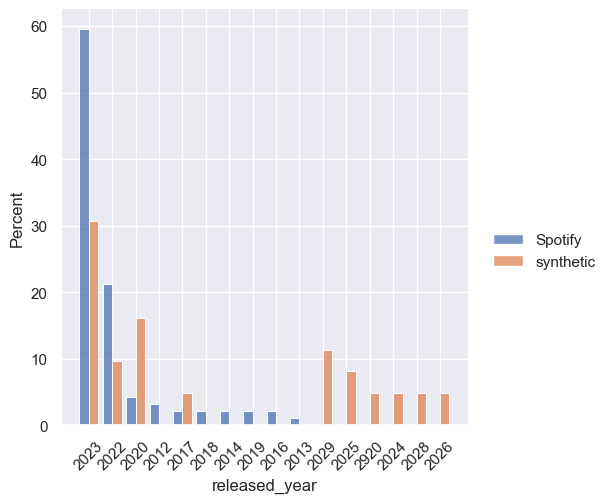

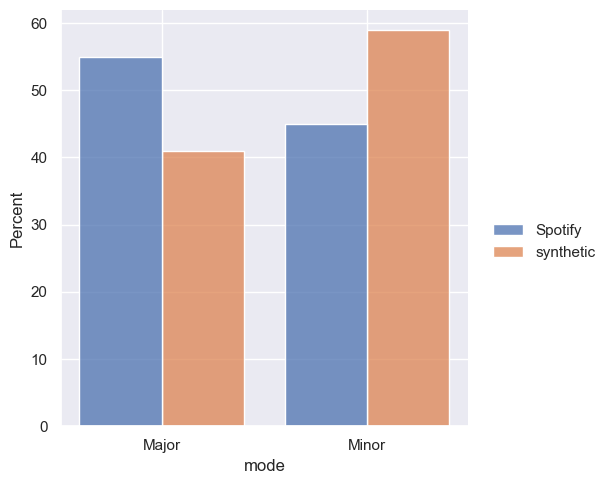

In [13]:
for col in ["released_year", "mode"]:
    source_agg = rf.metrics.count_all(dataset, col, nlargest=10)
    syn_agg = rf.metrics.count_all(syn, col, nlargest=10)
    rf.labs.vis.plot_bar([source_agg, syn_agg], col, f"{col}_count")

**2. numerical columns**


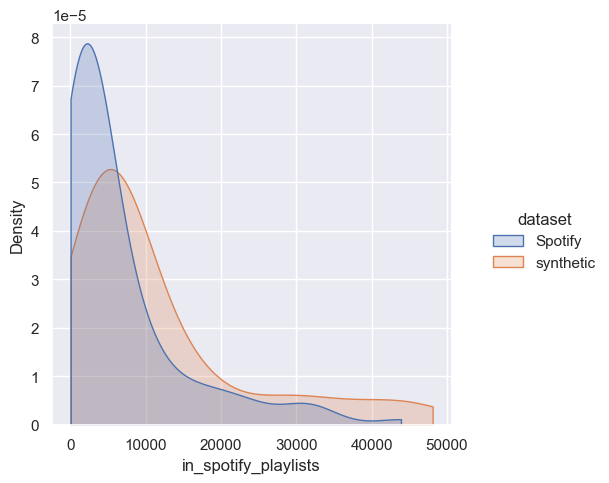

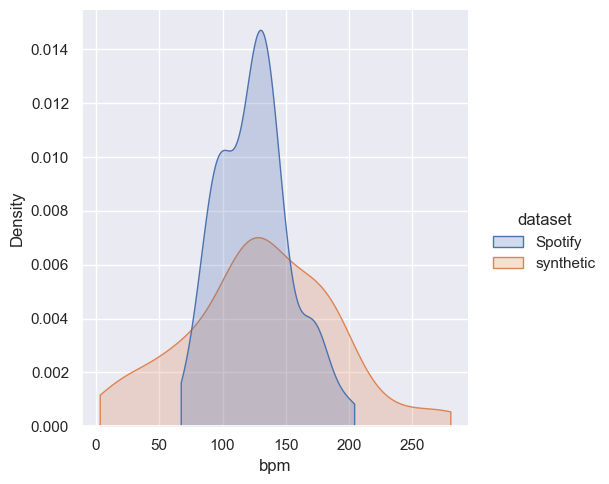

In [14]:
for col in ["in_spotify_playlists", "bpm"]:
    rf.labs.vis.plot_kde([dataset, syn], col)